# Download audio from outside of the habitat of the target species and make an absence dataset of the most confusing absent samples from this. 

### So far all the training data comes from habitats where the target species has been observed.  
One advantage of this is that the main differences between the present and absent samples is the bird call itself, and the environmental sounds will be the same in both the present and absent samples. This will protect againt a situation where a model might learn about associated environmental noise rather than the target bird call. 

### There might be species from outside these habitats which sound very similar to the target species.
In order to get a fairer picture of how the model will perform in production, the model needs testing on audio from outside the habitat of the target species to see how many false positives show up. 

It might be necessary to train the model on these clips to give a wider set of examples from the negative class. 



In [14]:
# imports
from pathlib import Path
import sys
import pandas as pd
BASE_PATH = Path.cwd().parent.parent
sys.path.append(str(BASE_PATH))
from src.utils import display_all, plot_locations, keep_cols
import src.data
from src.data import build
from src.utils import plot_locations, remove_short_clips, verify_samples

from pathlib import Path
model_save_path = BASE_PATH / "models"
sys.path.append(str(BASE_PATH))
import opensoundscape as opso
from opensoundscape import Audio, Spectrogram, SpectrogramPreprocessor
from opensoundscape.preprocess.utils import show_tensor
from opensoundscape.data_selection import resample
import matplotlib.pyplot as plt
import sklearn

# load the cleaned metadata


In [2]:
data_path = Path.cwd().parent.parent / "data"
train_df_path = Path.cwd().parent.parent / "data" / "interim" 
df_train: pd.DataFrame = pd.read_pickle(train_df_path / "cleaned_metadata.pkl")
df_train.head(2)

,organization,project,project_id,location,location_id,recording_date_time,recording_id,task_method,task_id,aru_task_status,...,spectrogram_url,clip_url,sensorId,tasks,status,recording_url,latitude,longitude,location_buffer_m,file_type
1623,BU,Alberta Archetypes,1501,P-E0-1-10,308678,2022-06-05 06:51:00,416962,no_restrictions,596169,Transcribed,...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,ARU,357,Active,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,52.644040,-115.140510,NaN,flac
1752,BU,Amplitude Quality Testing 2020,293,AM-403-SE2,36043,2017-06-15 04:46:00,92051,no_restrictions,87956,Transcribed,...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,ARU,174,Published - Private,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,54.607774,-110.681271,NaN,flac


# Download some recordings from other habitats and save them to disk

In [3]:
other_habitats = build.other_habitat_df(df_train, "OSFL", 0)

47222 not downloaded
downloading 0 clips
skipped 0 previously downloaded files


These 1000 recordings from outside of OSFL habitat come from 852 unique locations. 

In [4]:
other_habitats.location_id.nunique()

852

# Show the locations of these habitats on a map

The spatial distribution of these additional samples looks even across the areas where data is available. 

/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:270: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  points.plot(


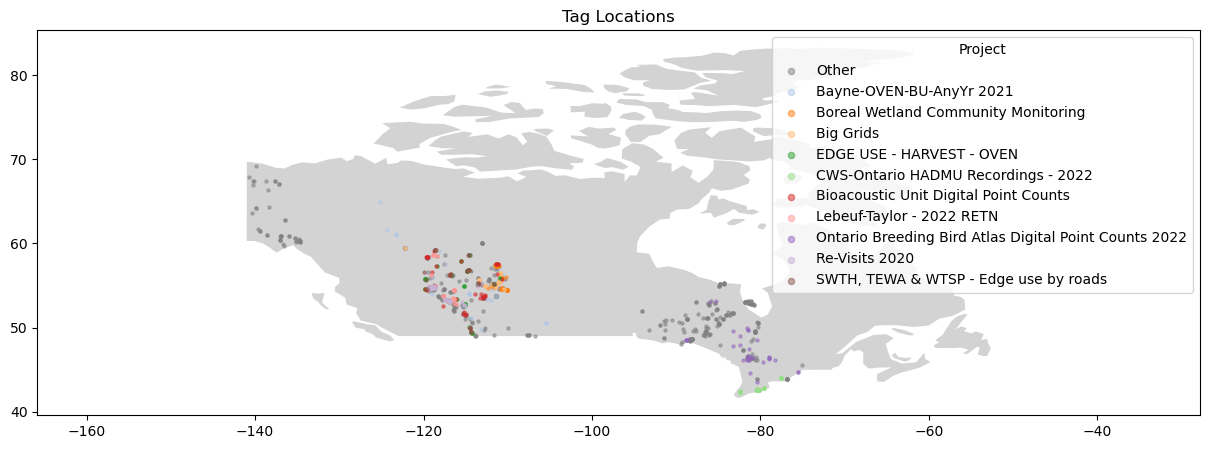

In [5]:
plot_locations(other_habitats)

In [36]:
# Set the present column to 0.0 and drop all other columns
other_habitats["target_present"] = 0.0
other_habitats = other_habitats[["target_present"]]

# Split the recordings into 3s chunks with 0.5 overlap and label them "present" = 0

In [37]:
other_habitats_ds = opso.AudioSplittingDataset(other_habitats, preprocessor=SpectrogramPreprocessor(3.0), overlap_fraction=0.5)

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/utils.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  clips[label_df.columns] = label_df.loc[f]
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/utils.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  clips[label_df.columns] = label_df.loc[f]
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/utils.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame

Save the labelled dataset to disk ready for cleaning. 

In [40]:
other_habitats_ds.label_df.to_pickle(data_path / "interim" / "train_and_valid_set" / "other_habitats_label_df.pkl")


# Cleaning the recordings from other locations
These recordings are taken from locations outside of the target species habitat and need verifying. 
These should all be labelled absent but there might be some target species recordings in here which need removing.

Confidence scores:
- 0 UNCHECKED means it hasn't been verified
- 1 DISCARD is something to throw out, 
- 2 UNSURE is not sure
- 3 VERIFIED means the absent label is correct
- 4 FOCAL Optionally tag as focal
- 5 Label needs changing to target present 

# Load the labelled dataset from disk if verification work has begun already


In [11]:
data_path = Path.cwd().parent.parent / "data"
df = pd.read_pickle(data_path / "interim" / "train_and_valid_set" / "other_habitats_label_df.pkl")

In [9]:
df.head()

target_present  \
file                                               start_time end_time                   
../../data/raw/recordings/OSFL_other_habitats/r... 0.0        3.0                  0.0   
                                                   1.5        4.5                  0.0   
                                                   3.0        6.0                  0.0   
                                                   4.5        7.5                  0.0   
                                                   6.0        9.0                  0.0   

                                                                        predicted  \
file                                               start_time end_time              
../../data/raw/recordings/OSFL_other_habitats/r... 0.0        3.0        0.073692   
                                                   1.5        4.5        0.152632   
                                                   3.0        6.0        0.090518   
                                                   4.5        7.5        0.133722   
                                                   6.0        9.0        0.155343   

                                                                            loss  \
file                                               start_time end_time             
../../data/raw/recordings/OSFL_other_habitats/r... 0.0        3.0       0.073692   
                                                   1.5        4.5       0.152632   
                                                   3.0        6.0       0.090518   
                                                   4.5        7.5       0.133722   
                                                   6.0        9.0       0.155343   

                                                                        confidence_cat  
file                                               start_time end_time                  
../../data/raw/recordings/OSFL_other_habitats/r... 0.0        3.0                    0  
                                                   1.5        4.5                    0  
                                                   3.0        6.0                    0  
                                                   4.5        7.5                    0  
                                                   6.0        9.0                    0

# skip over this if the training set cheking has already begun

# Load the model to make predictions on the training dataframe

In [39]:
model = opso.cnn.load_model(model_save_path / "whole-aardvark-191.model")

In [40]:
%load_ext autoreload
%autoreload 2


In [48]:
# predictions = model.predict(df, batch_size=64, activation_layer="sigmoid")

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:201: UserWarning: The columns of input samples df differ from `model.classes`.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

In [49]:
# Remove short clips if there were any
df = remove_short_clips(df)
# Then re-run the predictions. 

No short clips found in the dataframe.


In [50]:
predictions.rename(columns={"target_present": "predicted"}, inplace=True)
predictions.head()

,,,predicted
file,start_time,end_time,
../../data/raw/recordings/OSFL_other_habitats/recording-481565.flac,264.0,267.0,0.063300
../../data/raw/recordings/OSFL_other_habitats/recording-211686.mp3,532.5,535.5,0.055878
../../data/raw/recordings/OSFL_other_habitats/recording-319542.mp3,49.5,52.5,0.223485
../../data/raw/recordings/OSFL_other_habitats/recording-211729.mp3,183.0,186.0,0.033537
../../data/raw/recordings/OSFL_other_habitats/recording-414998.flac,0.0,3.0,0.078813


In [57]:
# sample_train_df_with_preds = pd.concat([sample_train_df, predictions], axis=1)
df = pd.concat([df, predictions], axis=1)
# df = df.loc[~df.predicted.isna()]

In [59]:
def calculate_loss(df):
    return abs(df["target_present"] - df["predicted"])
# Add a column to store the prediction error
df["loss"] = calculate_loss(df)

In [ ]:
# add a column to the dataframe to store the confidence of the label, if it doesn't alredy exist
if 'confidence_cat' not in df.columns:
    df['confidence_cat'] = 0
idx = 0
confidence = 0 # 0 means unchecked. 

In [ ]:
df.sample()

,,,present,probability,loss,confidence_cat
file,start_time,end_time,,,,
../../data/raw/recordings/OSFL_other_habitats/recording-98067.mp3,222.0,225.0,0.0,0.130419,0.130419,0


# If cleaning has begun, load the verified data instead
This will keep any previous verification work rather than starting from scratch. 

In [12]:
if Path.exists(data_path / "interim" / "train_and_valid_set" / "other_habitats_label_df_verified.pkl"):
    df = pd.read_pickle(data_path / "interim" / "train_and_valid_set" / "other_habitats_label_df_verified.pkl")
    df.rename(columns={"present": "target_present"}, inplace=True)
    df.rename(columns={"probability": "predicted"}, inplace=True)

In [13]:
df.target_present.value_counts()

target_present
0.0    168431
Name: count, dtype: int64


# Label the test set with confidence scores
This part of the notebook 

- takes a test set saved to disk as an AudioFileDataset (or just a pandas dataframe)
- loads each sample with playback option
- takes a user typed label as input
- saves the label in a column of the dataframe titled 'confidence' 
- saves the dataset back to disk



# Run this line and pass in a dataframe to verify samples. 

(PosixPath('../../data/raw/recordings/OSFL_other_habitats/recording-816177.flac'), 55.5, 58.5)
target = 0.0, prediction = 0.883679986000061 loss = 0.883679986000061


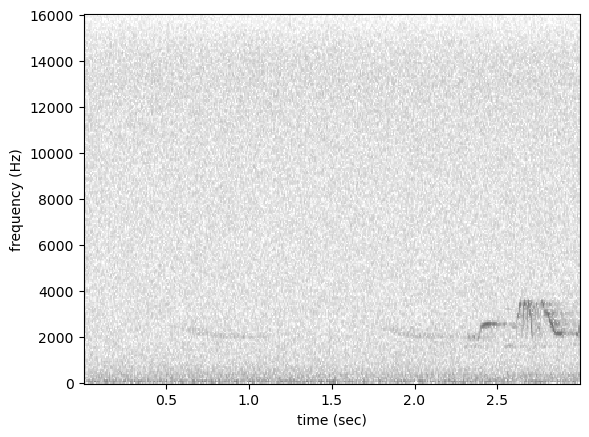

added confidence tag 3 to the dataframe.
verification counts for target_present = 0.0
confidence_cat
0    167273
3      1013
5       103
2        40
1         2
Name: count, dtype: int64


/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:398: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[clip_idx, "confidence_cat"] = int(user_confidence)


In [72]:
other_habitats_label_df_verified = verify_samples(df, ground_truth=0.0, loss_sorted=True)


In [73]:
df.loc[df["confidence_cat"] == 5, "target_present"] = 0.0

# Show the distribution of loss
The loss histogram shows that from the 1000 recordings taken from outside of the OSFL habitat, and therefore from outside of the initial training set, a large majority of these samples predicted OSFL presence with a score below 0.5. The total number of 3 second clips generated buy these 1000 recordings is 167274. 

93% of the clips scored below 0.5 and 98.5% scored below 0.8. 

A model trained on data from OSFL habitats only was used to make predictions on all of these clips. The clips were assumed all to have OSFL presence of 0, and all the clips were sorted by loss, or 'most confusing'. The most erroneous 1157 clips were manually verified. These top 1157 clips scored around 0.8 and above. 

After checking through the top 1157 sorted by model prediction score:

1157 total verified clips:  <br>
1012 Actual absent      <br>
103 Actual OSFL        <br>
40 Uncertain          <br>
2 Discarded          <br>

Text(0, 0.5, 'Count')

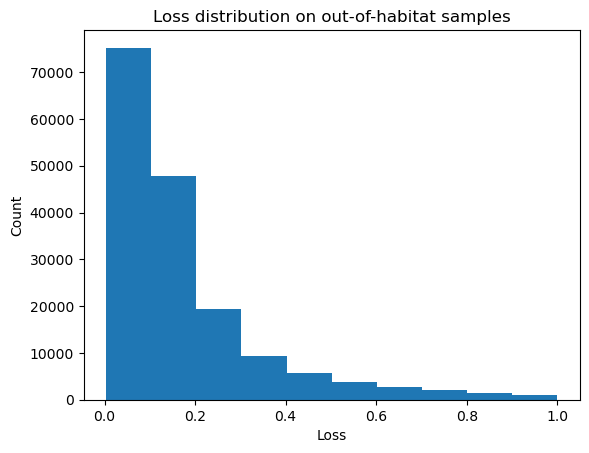

In [74]:
plt.hist(df.loss)
plt.title("Loss distribution on out-of-habitat samples")
plt.xlabel("Loss")
plt.ylabel("Count")

This histogram shows that there are relatively few confusing sounds in all the audio collected from outside the habitat of the target species, with only 1.5% of these audio samples scoring above 0.8

In [75]:
sum(df.loss < 0.8)/len(df)

0.9852758696439492

# Show how the frequency of actual OSFL samples decreases with score

<Axes: >

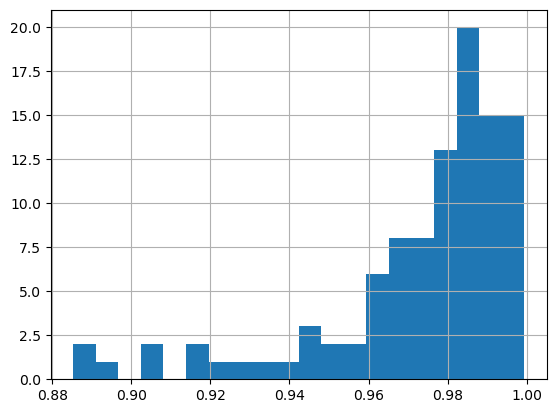

In [76]:
df = other_habitats_label_df_verified
df.loc[df.confidence_cat == 5].predicted.hist(bins=20)

In [77]:
other_habitats_label_df_verified.sample()

,,,target_present,predicted,loss,confidence_cat
file,start_time,end_time,,,,
../../data/raw/recordings/OSFL_other_habitats/recording-199966.mp3,450.0,453.0,0.0,0.104124,0.104124,0


After picking the 1000 most confusing 3 second clips from the recordings from other habitats, 290 unique locations end up being represented. This is because some recordings contain multiple segments of audio which are similar to the target vocalization. 

In [78]:
df[df.confidence_cat == 3].index.get_level_values('file').nunique()

290

# Save the validation work
This will save the training dataframe with a new column called 'confidence cat' which will show an extra layer of error checking, and allow us to re-label mislabelled samples. 


In [79]:
df.to_pickle(data_path / "interim" / "train_and_valid_set" / "other_habitats_label_df_verified.pkl")

In [80]:
other_habitats_label_df_verified.confidence_cat.value_counts()

confidence_cat
0    167273
3      1013
5       103
2        40
1         2
Name: count, dtype: int64

#### Because the validation work sorted all the samples in the out of habitat recordings by recognizer score, we have just made a dataset of 1000 audio samples which are most likely to be predicted as present by our recognizer, but which are in fact absent. Including these clips in the training set should make the model less likely to return false positives.

# Split the out of habitat samples into train, valid and test sets. 
Because the validation work sorted the clips by highest loss, sampling only from the confirmed clips will cut out many of the other types of sound to be found in this dataset. For this reason, we'll sample from the portion where the confidence category = 3, meaning confirmed, but also from where confidence category = 0, meaning unconfirmed. This will give a better spread of audio types from many habitats. 

In [20]:
confirmed_most_confused = df.loc[df.confidence_cat == 3].sample(1000)
not_verified = df.loc[df.confidence_cat == 0].sample(1000)
len(confirmed_most_confused), len(not_verified)

(1000, 1000)

In [42]:
train_and_valid_1, test_1 = sklearn.model_selection.train_test_split(confirmed_most_confused, test_size=0.25)

train_1, valid_1 = sklearn.model_selection.train_test_split(train_and_valid_1, test_size=0.3333)

train_and_valid_2, test_2 = sklearn.model_selection.train_test_split(not_verified, test_size=0.25)
train_2, valid_2 = sklearn.model_selection.train_test_split(train_and_valid_2, test_size=0.3333)

In [44]:
len(train_1), len(valid_1), len(test_1), len(train_2), len(valid_2), len(test_2)

(500, 250, 250, 500, 250, 250)

In [46]:
other_habitat_train = pd.concat([train_1, train_2]).sample(frac=1)
other_habitat_valid = pd.concat([valid_1, valid_2]).sample(frac=1)
other_habitat_test = pd.concat([test_1, test_2]).sample(frac=1)

Verify the unverified samples which were used to make up half of each dataset. 

In [561]:
other_habitat_train = verify_samples(other_habitat_train, ground_truth=0.0, loss_sorted=True, autolabel=3)

No unverified clips within chosen target class.


In [815]:
other_habitat_valid = verify_samples(other_habitat_valid, ground_truth=0.0, loss_sorted=True, autolabel=3)

No unverified clips within chosen target class.


In [1078]:
other_habitat_test = verify_samples(other_habitat_test, ground_truth=0.0, loss_sorted=True, autolabel=3)

No unverified clips within chosen target class.


In [818]:
# Remove any samples which cause an error in case they affect training. 
# other_habitat_train.drop((Path('../../data/raw/recordings/OSFL_other_habitats/recording-320770.mp3'), 261.0, 264.0), inplace=True)

# Save the verified data from other habitats. 

In [1079]:
other_habitat_train.to_pickle(data_path / "interim" / "train_set" / "other_habitat_train.pkl")
other_habitat_valid.to_pickle(data_path / "interim" / "valid_set" / "other_habitat_valid.pkl")
other_habitat_test.to_pickle(data_path / "interim" / "test_set" / "other_habitat_test.pkl")